In [2]:
# If you don't install pykrige before, please install it.

# ! pip install pykrige

In [3]:
import numpy as np
from scipy.interpolate import griddata, Rbf
import matplotlib.pyplot as plt
import json
import math
from sklearn.preprocessing import MinMaxScaler
from pprint import pprint
from shapely.geometry import Point, Polygon
from pykrige.ok3d import OrdinaryKriging3D

In [4]:
with open('data\calied_data.json') as json_file:
    ca_data = json.load(json_file)

In [5]:
len(ca_data)

4655

In [6]:
# Remove duplicate data

coords = []

for data in ca_data:
    coords.append([float(data['lat']), float(data['lon']), abs(float(data['rel_alt'])), float(data['temp'])])
    
t_r = []
    
for arr in coords:
    unique = True
    # Checks whether a subarray with the same first three elements as the current subarray is already in the result list.
    for res_arr in t_r:
        if np.array_equal(arr[:3], res_arr[:3]):
            unique = False
            break
    if unique:
        t_r.append(arr)


data_points = np.array(t_r)
    
pprint(len(data_points))
pprint(data_points[0])

2729
array([ 25.038885, 121.530971,   0.      ,  36.318   ])


In [7]:
data_points.max(axis=0)

array([ 25.04013 , 121.532689,  64.802   ,  41.578   ])

In [8]:
data_points.min(axis=0)

array([ 25.038617, 121.529412,   0.      ,  32.965   ])

In [9]:
data_coords = data_points[:, :3]

In [10]:
# Normalize all fields from minimum value 0 to maximum value 1.

scaler = MinMaxScaler(feature_range=(0, 1)).fit(data_coords)
data_points_r = scaler.transform(data_coords)

In [11]:
# Set the number of mesh divisions for the kriging method, please depend on the performance of the computer hardware.

# grid_x, grid_y, grid_z = np.meshgrid(
#     np.linspace(0, 1, 72),
#     np.linspace(0, 1, 52),
#     np.linspace(0, 1, 30)
# )

grid_x, grid_y, grid_z = np.meshgrid(
    np.linspace(0, 1, 180),
    np.linspace(0, 1, 130),
    np.linspace(0, 1, 30),
)
# grid_x, grid_y, grid_z = np.meshgrid(
#     np.linspace(0, 1, 10),  //360
#     np.linspace(0, 1, 10),  //260
#     np.linspace(0, 1, 10)   //60
# )

In [12]:
# Extract the coordinates and values of the original data points.

data_coordinates = data_points_r[:, :3]
data_values = data_points[:, 3]

pprint(data_coordinates[0])
pprint(data_values[0])

array([0.17713153, 0.47574001, 0.        ])
36.318


In [13]:
len(data_coordinates)

2729

In [14]:
# Interpolate for predefined grid points.

grid_points = np.column_stack((grid_x.flatten(), grid_y.flatten(), grid_z.flatten()))
interpolated_values = griddata((data_coordinates[:, 0], data_coordinates[:, 1], data_coordinates[:, 2]), data_values, grid_points, method='linear')

# Reshape interpolation results into a shape consistent with the mesh.

interpolated_values = interpolated_values.reshape(grid_x.shape)

In [15]:
len(interpolated_values.flatten())

702000

In [16]:
# Get the coordinates of the interpolation point.

interpolated_coordinates = np.column_stack((grid_x.flatten(), grid_y.flatten(), grid_z.flatten()))

i_xs_f = []
i_ys_f = []
i_zs_f = []

# Output the coordinates and interpolation value of each interpolation point.

for i in range(len(interpolated_coordinates)):
    x_i, y_i, z_i = interpolated_coordinates[i]
    value_i = interpolated_values.flatten()[i]
    if math.isnan(value_i) is False:
        i_xs_f.append(x_i)
        i_ys_f.append(y_i)
        i_zs_f.append(z_i)

In [23]:
def building_filter(x, y, z, iv):
    result = []
    for i in range(len(x)):
        result.append([x[i], y[i], z[i]])
    
    result_inverse = scaler.inverse_transform(result)
    result_inverse[10]
    buildingsData = json.load(open('data/buildings.json'))
    new_result = []
    new_value = []
                       
    for i in range(len(result_inverse)):
        r = result_inverse[i]
        sa = True
        for feature in buildingsData['features']:
            height = feature['properties']['height']
            coords = feature['geometry']['coordinates'][0]
            polygon = Polygon(coords)
            if polygon.contains(Point(r[1], r[0])):
                if r[2] <= height:
                    sa = False
                    break
        if sa:
            new_result.append(result[i])
            new_value.append(iv[i])

    nd_nr = np.array(new_result)
    nd_nv = np.array(new_value)
    
    return nd_nr, nd_nv

In [24]:
# Remove coords that intersect street buildings

nr, nv = building_filter(i_xs_f, i_ys_f, i_zs_f, interpolated_values.flatten())

In [25]:
i_xs = nr[:, 0]
i_ys = nr[:, 1]
i_zs = nr[:, 2]

ic = nv
i_xs

array([0.10055866, 0.10055866, 0.10055866, ..., 0.61452514, 0.61452514,
       0.61452514])

In [26]:
pprint(len(i_xs))
pprint(len(i_ys))
pprint(len(i_zs))
pprint(len(ic))

nr

365045
365045
365045
365045


array([[0.10055866, 0.00775194, 0.03448276],
       [0.10055866, 0.00775194, 0.06896552],
       [0.10055866, 0.00775194, 0.10344828],
       ...,
       [0.61452514, 0.99224806, 0.82758621],
       [0.61452514, 0.99224806, 0.86206897],
       [0.61452514, 0.99224806, 0.89655172]])

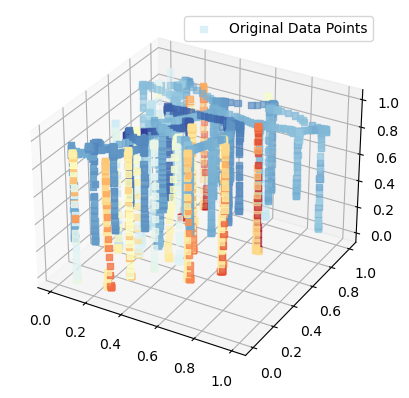

In [27]:
# Draw predefined grids and interpolate results 1.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_coordinates[:, 0], data_coordinates[:, 1], data_coordinates[:, 2], c=data_values, cmap='RdYlBu_r', marker='s', label='Original Data Points')
ax.legend()
plt.show()

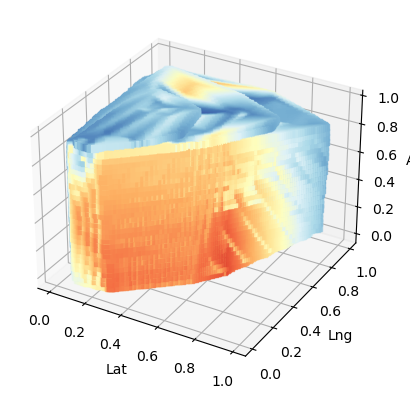

In [28]:
# Draw predefined grids and interpolate results 2.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(data_coordinates[:, 0], data_coordinates[:, 1], data_coordinates[:, 2], c=data_values, cmap='viridis', s=50, label='Original Data Points')
ax.scatter(grid_x, grid_y, grid_z, c=interpolated_values.flatten(), cmap='RdYlBu_r', marker='s')
ax.set_xlabel('Lat')
ax.set_ylabel('Lng')
ax.set_zlabel('Alt')

# ax.legend()
plt.show()

In [29]:
ok3d = OrdinaryKriging3D(
    data_coordinates[:, 0], data_coordinates[:, 1], data_coordinates[:, 2], data_values, variogram_model="linear"
)

In [30]:
k3d1, ss3d = ok3d.execute("points", i_xs, i_ys, i_zs, backend='loop')

In [31]:
len(k3d1)

365045

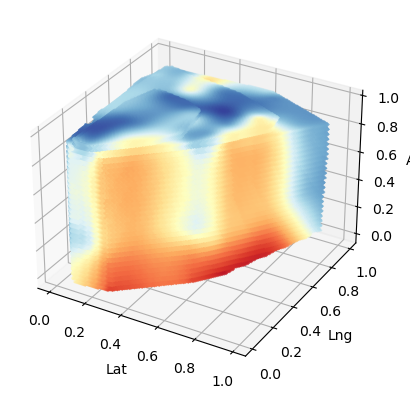

In [32]:
# Plot raw data points.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(data_coordinates[:, 0], data_coordinates[:, 1], data_coordinates[:, 2], c=data_values, cmap='viridis', label='Original Data')

# Plot interpolation results.
ax.scatter(i_xs, i_ys, i_zs, c=k3d1, cmap='RdYlBu_r', marker='x')

ax.set_xlabel('Lat')
ax.set_ylabel('Lng')
ax.set_zlabel('Alt')
# ax.legend()

plt.show()

In [33]:
len(i_xs)

365045

In [34]:
# Restore normalized coordinates to real coordinates

result = []
for i in range(len(i_xs)):
    result.append([i_xs[i], i_ys[i], i_zs[i]])

result_inverse = scaler.inverse_transform(result)
result_inverse = result_inverse.tolist()

In [35]:
for i in range(len(result_inverse)):
    result_inverse[i].append(k3d1[i])
    
result_inverse[0]

[25.038769145251393, 121.52943740310077, 2.234551724137931, 36.88836681608716]

In [36]:
len(result_inverse)

365045

In [39]:
with open('data/230901K.json', 'w') as json_file:
    json.dump(result_inverse, json_file, indent=4)